In [ ]:
!unzip Emotion.zip

In [2]:
# Import All required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
import cv2

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

In [4]:
# Define paths
dataset_path = "/content/images/train"
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [5]:
# Initialize lists to store images and labels
images = []
labels = []

In [6]:
# Load images
for i, emotion in enumerate(emotions):
    emotion_path = os.path.join(dataset_path, emotion)
    for image_file in os.listdir(emotion_path):
        img = cv2.imread(os.path.join(emotion_path, image_file), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (48, 48))
        images.append(img)
        labels.append(i)

In [7]:
# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [8]:
# Normalize pixel values
images = images / 255.0

In [9]:
# One-hot encode labels
labels = to_categorical(labels)

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [11]:
# Add channel dimension (for CNN input)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [12]:
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (23056, 48, 48, 1)
Test data shape: (5765, 48, 48, 1)


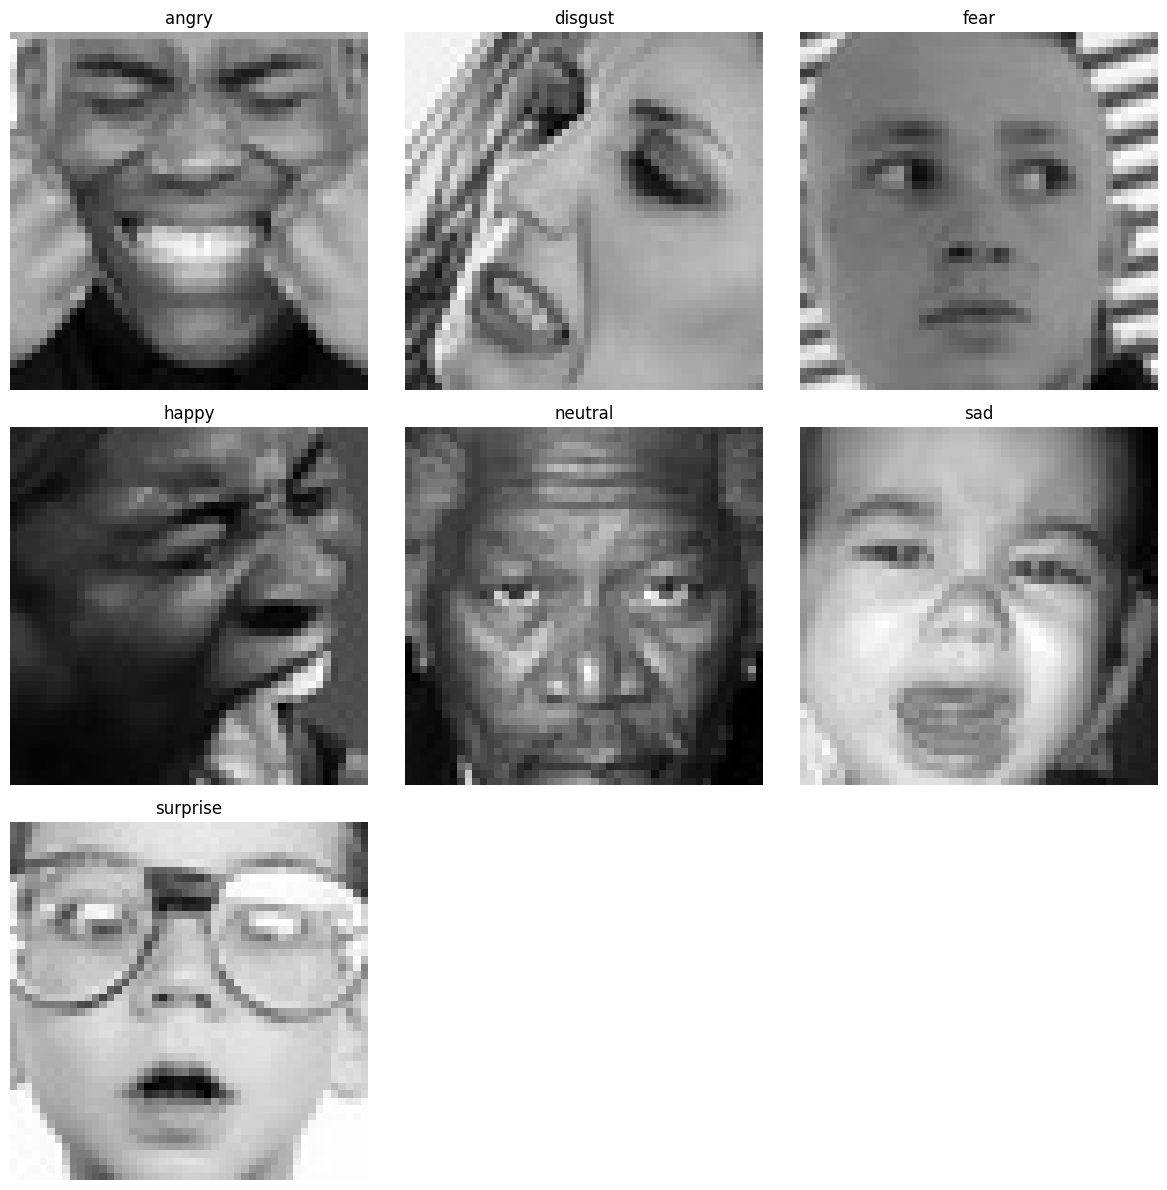

In [13]:
# Plot sample images from each class
plt.figure(figsize=(12, 12))
for i in range(7):
    # Get first image for each emotion
    idx = np.where(np.argmax(labels, axis=1) == i)[0][0]
    plt.subplot(3, 3, i+1)
    plt.imshow(images[idx].squeeze(), cmap='gray')
    plt.title(emotions[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

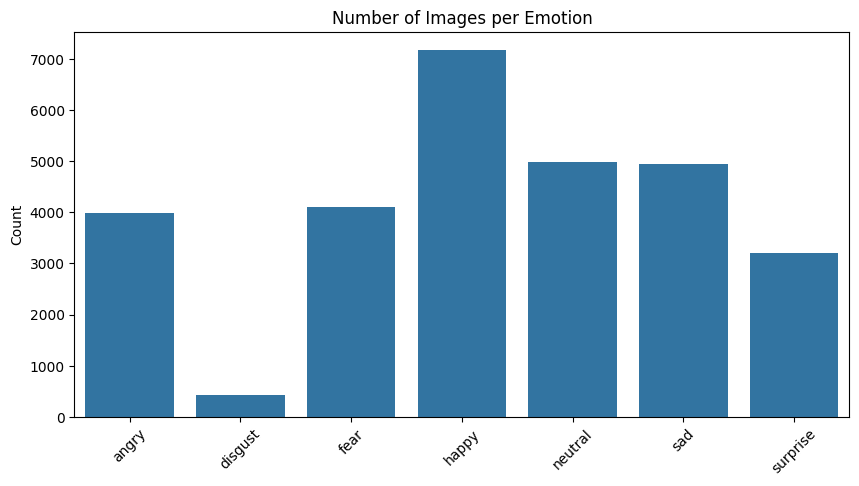

In [14]:
# Plot distribution of classes
label_counts = np.sum(labels, axis=0)
plt.figure(figsize=(10, 5))
sns.barplot(x=emotions, y=label_counts)
plt.title('Number of Images per Emotion')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [15]:
def build_cnn_model(input_shape=(48, 48, 1), num_classes=7):
    model = Sequential()
    # Block 1
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [16]:
cnn_model = build_cnn_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,872,583 (22.40 MB)

 Trainable params: 5,869,767 (22.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

## Hybrid Model - CNN + LSTM

In [18]:
def build_cnn_lstm_model(input_shape=(48, 48, 1), num_classes=7, timesteps=5):
    # CNN part
    cnn_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(cnn_input)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Prepare for LSTM
    cnn_model = Model(inputs=cnn_input, outputs=x)

    # LSTM part
    lstm_input = Input(shape=(timesteps,) + input_shape)

    # Process each frame through CNN
    time_distributed = TimeDistributed(cnn_model)(lstm_input)
    time_distributed = TimeDistributed(Flatten())(time_distributed)

    # LSTM layers
    lstm_out = LSTM(128, return_sequences=True)(time_distributed)
    lstm_out = LSTM(128)(lstm_out)

    # Fully connected layers
    x = Dense(256, activation='relu')(lstm_out)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=lstm_input, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [19]:
def create_sequences(X, y, timesteps=5):
    X_seq = np.array([np.stack([x]*timesteps, axis=0) for x in X])
    return X_seq, y

In [20]:
X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_test_seq, y_test_seq = create_sequences(X_test, y_test)

In [21]:
cnn_lstm_model = build_cnn_lstm_model()
cnn_lstm_model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 5, 48, 48, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5, 6, 6, 256)   │     1,147,840 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 9216)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 128)         │     4,784,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,098,887 (23.27 MB)

 Trainable params: 6,097,095 (23.26 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [22]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [23]:
# Train CNN model
print("Training CNN model...")
cnn_history = cnn_model.fit(X_train, y_train,batch_size=64,epochs=10,validation_data=(X_test, y_test),callbacks=[reduce_lr, early_stop],verbose=1)

Training CNN model...
Epoch 1/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - accuracy: 0.2641 - loss: 2.3186 - val_accuracy: 0.2118 - val_loss: 2.0271 - learning_rate: 0.0010
Epoch 2/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.4380 - loss: 1.5091 - val_accuracy: 0.4819 - val_loss: 1.3431 - learning_rate: 0.0010
Epoch 3/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.5203 - loss: 1.2652 - val_accuracy: 0.5297 - val_loss: 1.2524 - learning_rate: 0.0010
Epoch 4/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.5578 - loss: 1.1649 - val_accuracy: 0.5497 - val_loss: 1.2040 - learning_rate: 0.0010
Epoch 5/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.5992 - loss: 1.0658 - val_accuracy: 0.5487 - val_loss: 1.2289 - learning_rate: 0.0010
Epoch 6/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.6232 - loss: 1.0134 - val_accuracy: 0.5783 - val_loss: 1.1298 - learning_rate: 0.0010
Epoch 7/10
361/361 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step 

In [24]:
# Train CNN-LSTM model
print("\nTraining CNN-LSTM model...")
cnn_lstm_history = cnn_lstm_model.fit(X_train_seq, y_train_seq,
    batch_size=32,epochs=10,validation_data=(X_test_seq, y_test_seq),
    callbacks=[reduce_lr, early_stop],verbose=1)


Training CNN-LSTM model...
Epoch 1/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 130s 160ms/step - accuracy: 0.2747 - loss: 1.7524 - val_accuracy: 0.3936 - val_loss: 1.5470 - learning_rate: 5.0000e-04
Epoch 2/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 132s 150ms/step - accuracy: 0.4352 - loss: 1.4284 - val_accuracy: 0.4947 - val_loss: 1.3184 - learning_rate: 5.0000e-04
Epoch 3/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 147s 157ms/step - accuracy: 0.5060 - loss: 1.2873 - val_accuracy: 0.5265 - val_loss: 1.2388 - learning_rate: 5.0000e-04
Epoch 4/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 108s 150ms/step - accuracy: 0.5527 - loss: 1.1753 - val_accuracy: 0.5514 - val_loss: 1.1828 - learning_rate: 5.0000e-04
Epoch 5/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 109s 150ms/step - accuracy: 0.5836 - loss: 1.1059 - val_accuracy: 0.5677 - val_loss: 1.1425 - learning_rate: 5.0000e-04
Epoch 6/10
721/721 ━━━━━━━━━━━━━━━━━━━━ 146s 156ms/step - accuracy: 0.6147 - loss: 1.0304 - val_accuracy: 0.5754 - val_loss: 1.1355 - learning_rate: 5.0000e-04
Epoch 7/10
7

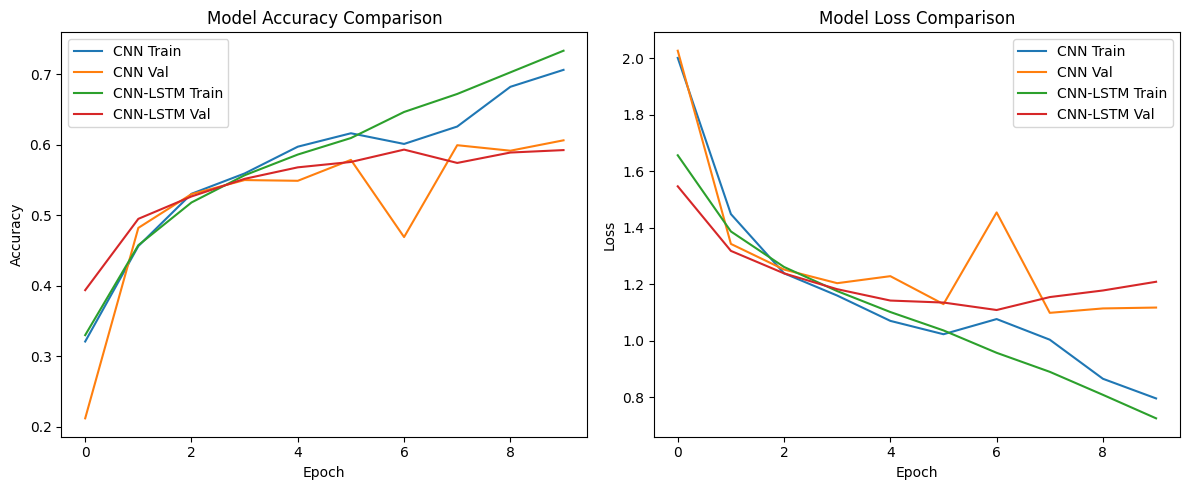

In [25]:
# Plot training history comparison
plt.figure(figsize=(12, 5))

# Accuracy comparison
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='CNN Train')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val')
plt.plot(cnn_lstm_history.history['accuracy'], label='CNN-LSTM Train')
plt.plot(cnn_lstm_history.history['val_accuracy'], label='CNN-LSTM Val')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss comparison
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='CNN Train')
plt.plot(cnn_history.history['val_loss'], label='CNN Val')
plt.plot(cnn_lstm_history.history['loss'], label='CNN-LSTM Train')
plt.plot(cnn_lstm_history.history['val_loss'], label='CNN-LSTM Val')
plt.title('Model Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# Evaluate models
print("CNN Model Evaluation:")
cnn_results = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {cnn_results[0]:.4f}")
print(f"Test Accuracy: {cnn_results[1]:.4f}")

print("\nCNN-LSTM Model Evaluation:")
cnn_lstm_results = cnn_lstm_model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"Test Loss: {cnn_lstm_results[0]:.4f}")
print(f"Test Accuracy: {cnn_lstm_results[1]:.4f}")

CNN Model Evaluation:
Test Loss: 1.0990
Test Accuracy: 0.5991

CNN-LSTM Model Evaluation:
Test Loss: 1.1091
Test Accuracy: 0.5929


In [27]:
# Save models
cnn_model.save('facial_expression_cnn.h5')
cnn_lstm_model.save('facial_expression_cnn_lstm.h5')